# UDLF Non-Local Means (RL-RECOM)
Images and data collected from experiments of UDLF Non-Local Means with RL-RECOM as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

# Enable relative imports (snippet of code based on https://stackoverflow.com/a/61079434)
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

from nlmeans.nlmeans import nlmeans
from nlmeans.nlmeans_udlf import nlmeans_udlf

from parameters import *
from utils import *

## Parameters

In [2]:
udl_method = 'RLRECOM'
udl_params = get_udl_params(udl_method)
print(udl_method, udl_params)

RLRECOM {'k': 3, 'lambda': 2, 'epsilon': 0.0125}


In [3]:
parent_dir = os.path.join(dir1, 'output', 'final_tests', f'{udl_method}_SSIM_{seed}')
if save_data:
    from pathlib import Path
    out_dir = os.path.join(parent_dir, shape)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(out_dir)

/home/murilo/Projetos/nlmeans_sar_py/output/final_tests/RLRECOM_SSIM_42/disk


In [4]:
%%script echo skipping
from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

skipping


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

<Figure size 640x480 with 0 Axes>

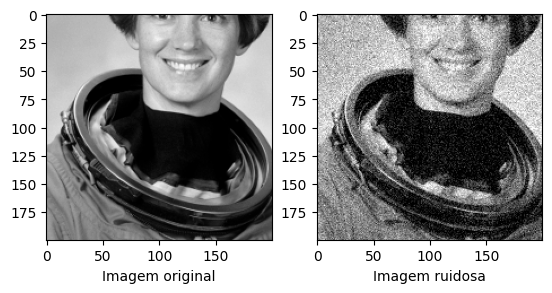

In [5]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

plt.set_cmap('gray')
plt.figure()

plt.subplot(1, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(1, 2, 2)
plt.xlabel('Imagem ruidosa')
plt.imshow(im_nse)
plt.show()

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 831 ms, sys: 3.1 ms, total: 834 ms
Wall time: 833 ms


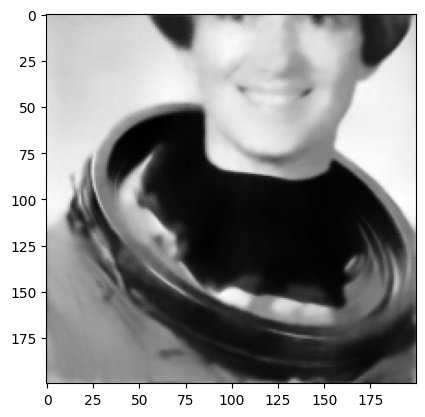

In [6]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1, cmap='gray')

## UDLF Non-Local Means (NONE)
The results of the reranking method will be compared with Non-Local Means using the original ranked lists, that is, the ranked lists used as input to UDLF. 

CPU times: user 6.09 s, sys: 311 ms, total: 6.4 s
Wall time: 6.4 s


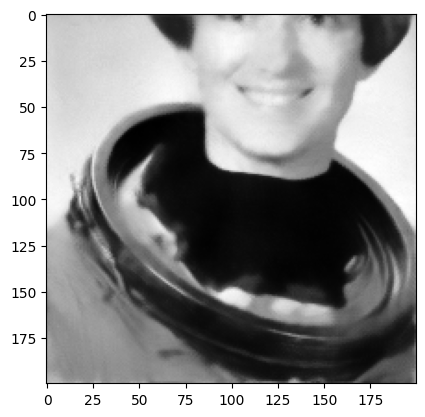

In [7]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()
plt.imshow(im_fil3, cmap='gray')

## UDLF Non-Local Means (RL-RECOM)
This denoise the image using RL-RECOM as the reranking method and considering RLRECOM default parameters as indicated in the [UDLF config.ini](https://github.com/UDLF/UDLF/blob/master/bin/config.ini)

CPU times: user 6.18 s, sys: 356 ms, total: 6.53 s
Wall time: 12.6 s


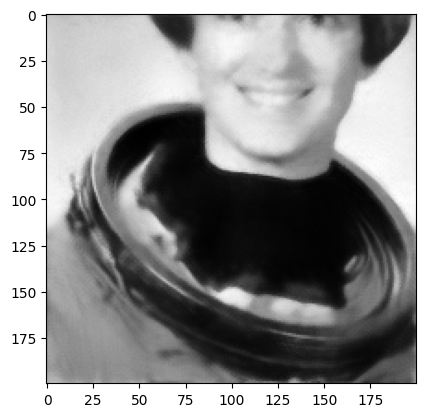

In [8]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()
plt.imshow(im_fil2, cmap='gray')

### Show the images side by side

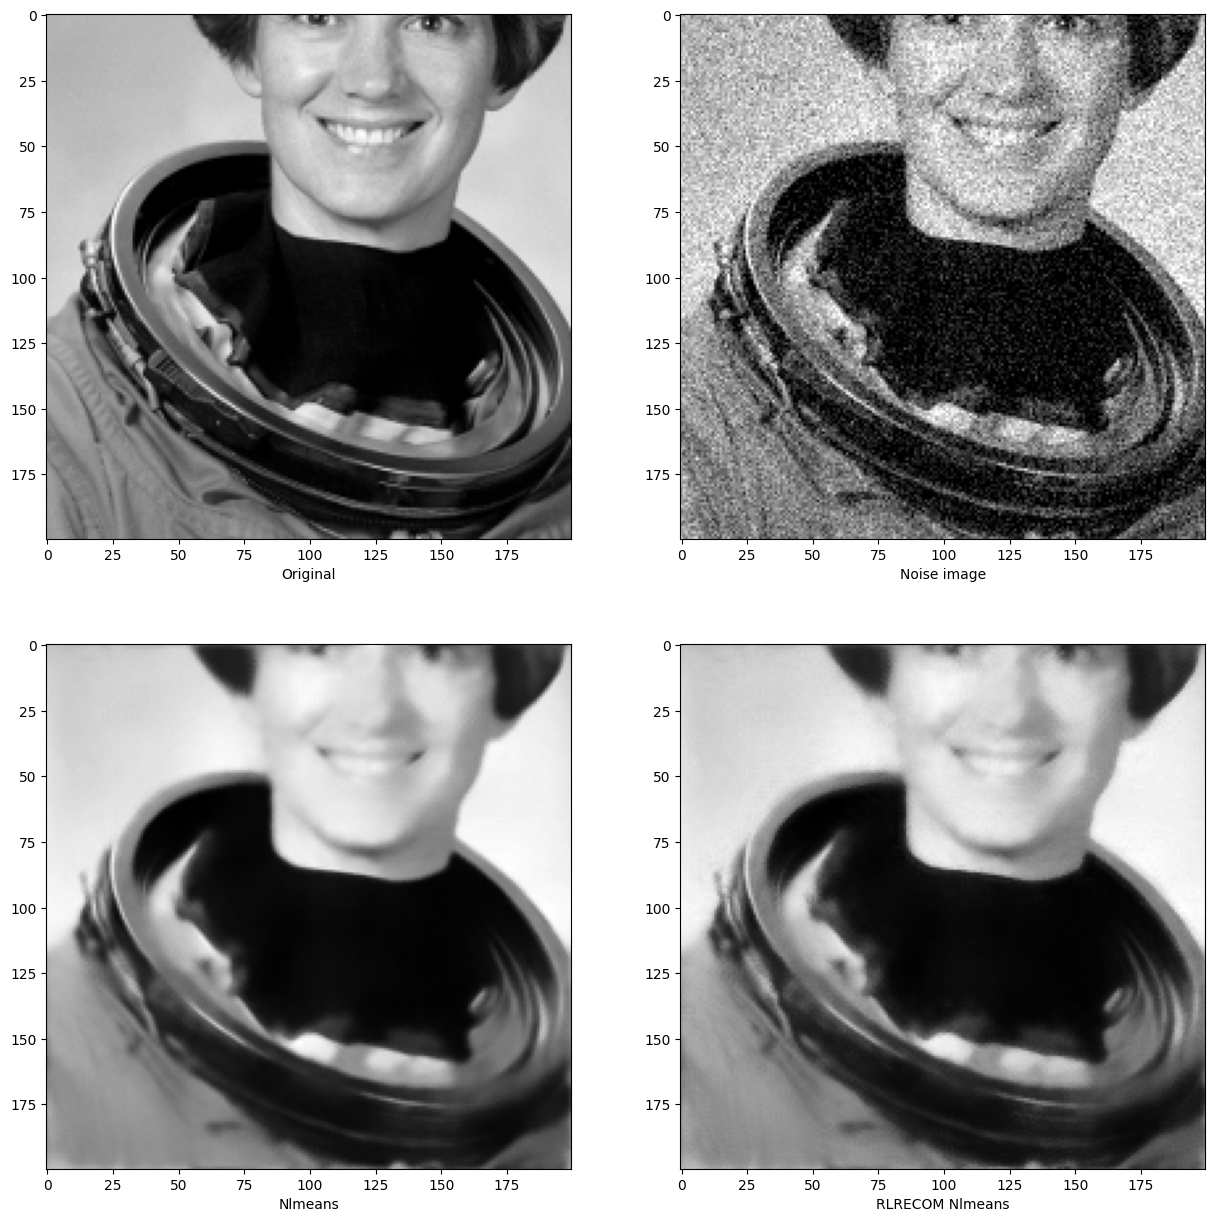

Noise    Nlmeans  RLRECOM Nlmeans  NONE Nlmeans
PSNR  20.582626  23.142633        23.160789     23.327438
SSIM   0.450165   0.679699         0.683314      0.687343
MSE    0.008745   0.003362         0.003388      0.003233

In [9]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

### K

In [10]:
%%time
# For speed porpuses only a subset of the values accepted by k will be tested (testing all the possible values for k
# could spend up to 80 hours).
start    = 3
end      = 22
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
ssims    = np.zeros(iter_num)
ssim_max = 0
best_k   = start
best_im  = None

for i, k in enumerate(possible_values):
    udl_params['k'] = k
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        ssim_value = image_metrics(im, im_fil3)[1] 
        print(udl_params, ssim_value, sep='\t')
        if ssim_value > ssim_max:
            ssim_max = ssim_value
            best_k   = k
            best_im  = im_fil3
        ssims[i] = ssim_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['k'] = best_k
print('\nFinal params:')
print(udl_params, ssim_max, sep='\t')

{'k': 3, 'lambda': 2, 'epsilon': 0.0125}	0.683313737628157
{'k': 4, 'lambda': 2, 'epsilon': 0.0125}	0.6831428977144454
{'k': 5, 'lambda': 2, 'epsilon': 0.0125}	0.6829382222105088
{'k': 6, 'lambda': 2, 'epsilon': 0.0125}	0.6824301699428547
{'k': 7, 'lambda': 2, 'epsilon': 0.0125}	0.6823339889453749
{'k': 8, 'lambda': 2, 'epsilon': 0.0125}	0.6819012602754275
{'k': 9, 'lambda': 2, 'epsilon': 0.0125}	0.6819825821543942
{'k': 10, 'lambda': 2, 'epsilon': 0.0125}	0.6815626553887442
{'k': 11, 'lambda': 2, 'epsilon': 0.0125}	0.6813566106229939
{'k': 12, 'lambda': 2, 'epsilon': 0.0125}	0.6815838316858224
{'k': 13, 'lambda': 2, 'epsilon': 0.0125}	0.6808474699590602
{'k': 14, 'lambda': 2, 'epsilon': 0.0125}	0.6802319340951182
{'k': 15, 'lambda': 2, 'epsilon': 0.0125}	0.6799818625019077
{'k': 16, 'lambda': 2, 'epsilon': 0.0125}	0.6792923882990469
{'k': 17, 'lambda': 2, 'epsilon': 0.0125}	0.6788963445600822
{'k': 18, 'lambda': 2, 'epsilon': 0.0125}	0.6097139400814543
{'k': 19, 'lambda': 2, 'epsilon'

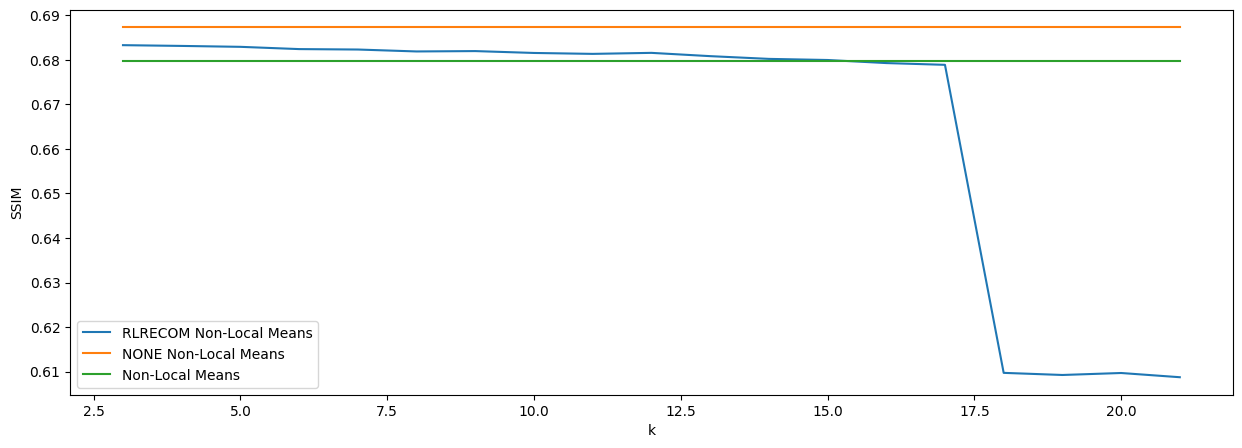

In [11]:
udlf_plot, = plt.plot(possible_values, ssims, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_ssim] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_ssim] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k')
plt.ylabel('SSIM')
if save_data:
    plt.savefig(os.path.join(out_dir, 'k_tuning_plot.png'))

### Lambda

In [12]:
%%time
start    = 2
end      = 22
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
ssims    = np.zeros(iter_num)
best_lbd = start

for i, lbd in enumerate(possible_values):
    udl_params['lambda'] = lbd
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        ssim_value = image_metrics(im, im_fil3)[1] 
        print(udl_params, ssim_value, sep='\t')
        if ssim_value > ssim_max:
            ssim_max = ssim_value
            best_lbd = lbd
            best_im  = im_fil3
        ssims[i] = ssim_value
    except:
        print('Finished with error on param:', lbd)
        break
        
# Update method parameters
udl_params['lambda'] = best_lbd
print('\nFinal params:')
print(udl_params, ssim_max, sep='\t')

{'k': 3, 'lambda': 2, 'epsilon': 0.0125}	0.683313737628157
{'k': 3, 'lambda': 3, 'epsilon': 0.0125}	0.6833713073868812
{'k': 3, 'lambda': 4, 'epsilon': 0.0125}	0.6833674125008328
{'k': 3, 'lambda': 5, 'epsilon': 0.0125}	0.6834054383871772
{'k': 3, 'lambda': 6, 'epsilon': 0.0125}	0.6834129705391991
{'k': 3, 'lambda': 7, 'epsilon': 0.0125}	0.6834201001438975
{'k': 3, 'lambda': 8, 'epsilon': 0.0125}	0.6834159239556044
{'k': 3, 'lambda': 9, 'epsilon': 0.0125}	0.6834319369419702
{'k': 3, 'lambda': 10, 'epsilon': 0.0125}	0.6834437611918778
{'k': 3, 'lambda': 11, 'epsilon': 0.0125}	0.6834216961249608
{'k': 3, 'lambda': 12, 'epsilon': 0.0125}	0.6834416136982483
{'k': 3, 'lambda': 13, 'epsilon': 0.0125}	0.6834293962068058
{'k': 3, 'lambda': 14, 'epsilon': 0.0125}	0.6834809747340371
{'k': 3, 'lambda': 15, 'epsilon': 0.0125}	0.6834637735298458
{'k': 3, 'lambda': 16, 'epsilon': 0.0125}	0.6834328911148995
{'k': 3, 'lambda': 17, 'epsilon': 0.0125}	0.6834391689154169
{'k': 3, 'lambda': 18, 'epsilon':

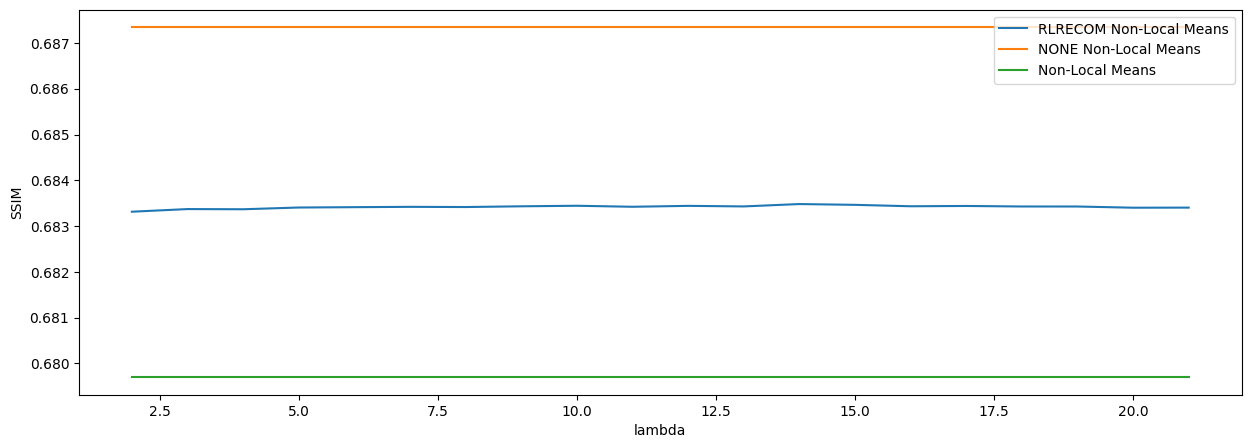

In [13]:
udlf_plot, = plt.plot(possible_values, ssims, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_ssim] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_ssim] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('lambda')
plt.ylabel('SSIM')
if save_data:
    plt.savefig(os.path.join(out_dir, 'lambda_tuning_plot.png'))

### Epsilon

In [14]:
%%time
start    = 0.0125
end      = 0.05
step     = 0.002
possible_values = np.arange(start, end, step)
iter_num = len(possible_values)
ssims    = np.zeros(int(iter_num))
best_eps = start

for i, eps in enumerate(possible_values):
    eps = round(eps, 5)
    udl_params['epsilon'] = eps
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        ssim_value = image_metrics(im, im_fil3)[1] 
        print(udl_params, ssim_value, sep='\t')
        if ssim_value > ssim_max:
            ssim_max = ssim_value
            best_eps = eps
            best_im  = im_fil3
        ssims[i] = ssim_value
    except:
        print('Finished with error on param:', eps)
        break
        
# Update method parameters
udl_params['epsilon'] = best_eps
print('\nFinal params:')
print(udl_params, ssim_max, sep='\t')

{'k': 3, 'lambda': 14, 'epsilon': 0.0125}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0145}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0165}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0185}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0205}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0225}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0245}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0265}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0285}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0305}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0325}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0345}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0365}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0385}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0405}	0.6834809747340371
{'k': 3, 'lambda': 14, 'epsilon': 0.0425}	0.6834809747340371
{'k': 3, 'lambda': 14, '

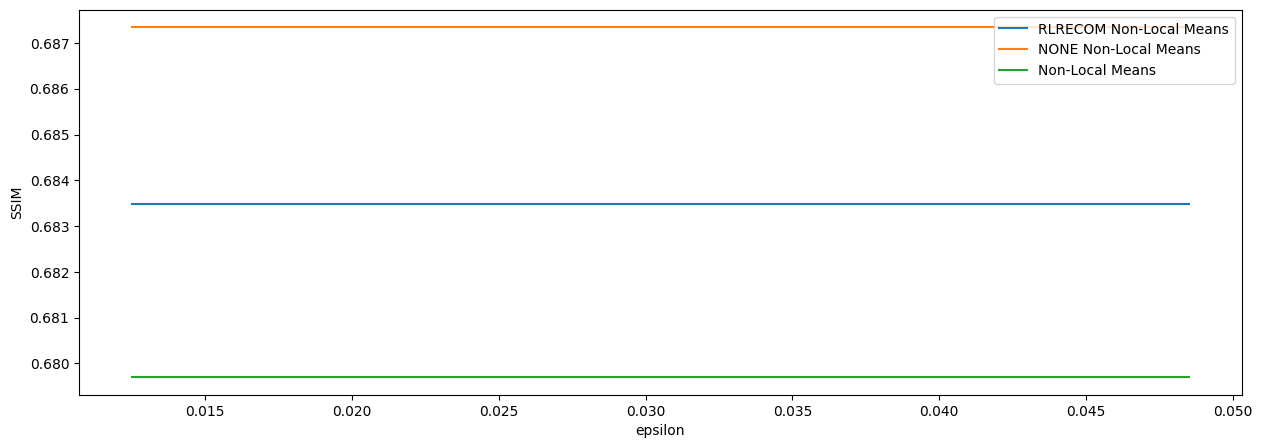

In [15]:
udlf_plot, = plt.plot(possible_values, ssims, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_ssim] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_ssim] * int(iter_num), label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('epsilon')
plt.ylabel('SSIM')
if save_data:
    plt.savefig(os.path.join(out_dir, 'epsilon_tuning_plot.png'))

### Final Result

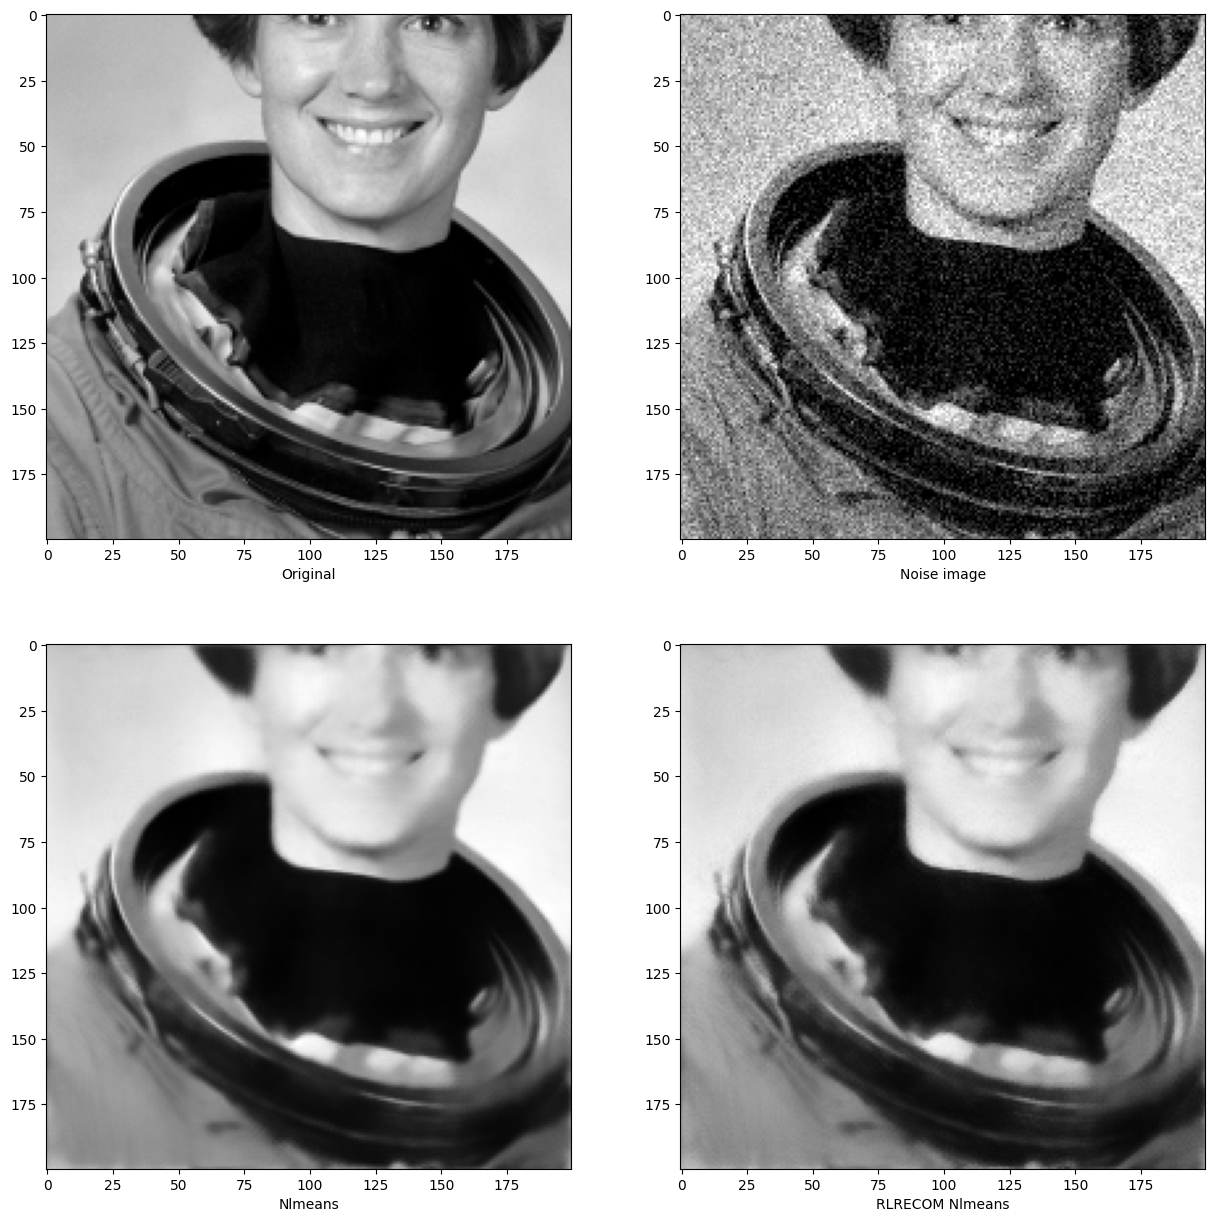

Noise    Nlmeans  RLRECOM Nlmeans  NONE Nlmeans
PSNR  20.582626  23.142633        23.165754     23.327438
SSIM   0.450165   0.679699         0.683481      0.687343
MSE    0.008745   0.003362         0.003384      0.003233

In [16]:
im_fil2 = best_im

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [17]:
%%time
import sys

eval_info = []
eval_psnr = []
eval_ssim = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    im, im_name = get_image(image)
    im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

    # In case of error, the functions above return None
    if im is None:
        continue
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 
    
    # Save the images if requested
    if save_data:
        plt.imsave(os.path.join(out_dir, f'{image}.png'), im)
        plt.imsave(os.path.join(out_dir, f'{image}_noise.png'), im_nse)
        plt.imsave(os.path.join(out_dir, f'{image}_nlm.png'), im_fil1)
        plt.imsave(os.path.join(out_dir, f'{image}_{udl_method}.png'), im_fil2)
        plt.imsave(os.path.join(out_dir, f'{image}_NONE.png'), im_fil3)

    # Evaluation
    im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
    im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
    im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
    im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    eval_ssim.append([im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape, im.dtype)

Method: RLRECOM
Parameters: {'k': 3, 'lambda': 14, 'epsilon': 0.0125}
Tested with image: astronaut (200, 200) float64
Tested with image: binary_blobs (200, 200) float64
Tested with image: brick (200, 200) float64
Tested with image: camera (200, 200) float64
Tested with image: cat (200, 200) float64
Tested with image: checkerboard (200, 200) float64
Tested with image: clock (200, 200) float64
Tested with image: coffee (200, 200) float64
Tested with image: coins (200, 200) float64
Tested with image: eagle (200, 200) float64
Tested with image: grass (200, 200) float64
Tested with image: gravel (200, 200) float64
Tested with image: horse (200, 200) float64
Tested with image: page (191, 191) float64
Tested with image: text (172, 172) float64
Tested with image: rocket (200, 200) float64
CPU times: user 3min 22s, sys: 11.4 s, total: 3min 33s
Wall time: 6min 11s


### Results

In [18]:
results_psnr_df = pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'PSNR')
print('Number of images tested:', len(images_tested))
results_psnr_df.style.apply(highlight_best_values, axis=1)

RLRECOM {'k': 3, 'lambda': 14, 'epsilon': 0.0125} PSNR
Number of images tested: 16


In [19]:
results_ssim_df = pd.DataFrame(
    data = eval_ssim,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'SSIM')
print('Number of images tested:', len(images_tested))
results_ssim_df.style.apply(highlight_best_values, axis=1)

RLRECOM {'k': 3, 'lambda': 14, 'epsilon': 0.0125} SSIM
Number of images tested: 16


In [20]:
results_psnr_df[results_psnr_df['RLRECOM'] > results_psnr_df['Nlmeans']]

Noise    Nlmeans    RLRECOM       NONE
astronaut  20.582626  23.142633  23.165754  23.327438
cat        20.010958  22.303322  22.531343  22.572579

In [21]:
results_ssim_df[results_ssim_df['RLRECOM'] > results_ssim_df['Nlmeans']]

Noise   Nlmeans   RLRECOM      NONE
astronaut  0.450165  0.679699  0.683481  0.687343
cat        0.385863  0.518080  0.543922  0.542697

In [22]:
if save_data:
    import json
    results_psnr_df.to_csv(os.path.join(out_dir, 'results_psnr.csv'))
    results_ssim_df.to_csv(os.path.join(out_dir, 'results_ssim.csv'))
    with open(os.path.join(out_dir, 'params.json'), 'w') as fp:
        json.dump({
            'hP': hP,
            'hW': hW,
            'tau': tau,
            'sig': sig,
            'shape': shape,
            'n_w': n_w,
            'seed': seed,
            'udl_method': udl_method,
            'udl_params': udl_params,
            'tuning_method': 'simple'
        }, fp)

# Experiments with 'square' shape

## Parameters

In [23]:
image = 'astronaut'
shape = 'square'
udl_params = get_udl_params(udl_method)
print(udl_method, udl_params)

RLRECOM {'k': 3, 'lambda': 2, 'epsilon': 0.0125}


In [24]:
if save_data:
    from pathlib import Path
    out_dir = os.path.join(parent_dir, shape)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(out_dir)

/home/murilo/Projetos/nlmeans_sar_py/output/final_tests/RLRECOM_SSIM_42/square


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

In [25]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

## Initial execution

Executes the original NLM, NLM-UDLF and NLM-NONE for the image, only changing the shape parameter.

In [26]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

CPU times: user 957 ms, sys: 3.83 ms, total: 961 ms
Wall time: 960 ms


In [27]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()

CPU times: user 8.99 s, sys: 584 ms, total: 9.58 s
Wall time: 9.62 s


In [28]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()

CPU times: user 8.46 s, sys: 568 ms, total: 9.03 s
Wall time: 15.9 s


### Initial result

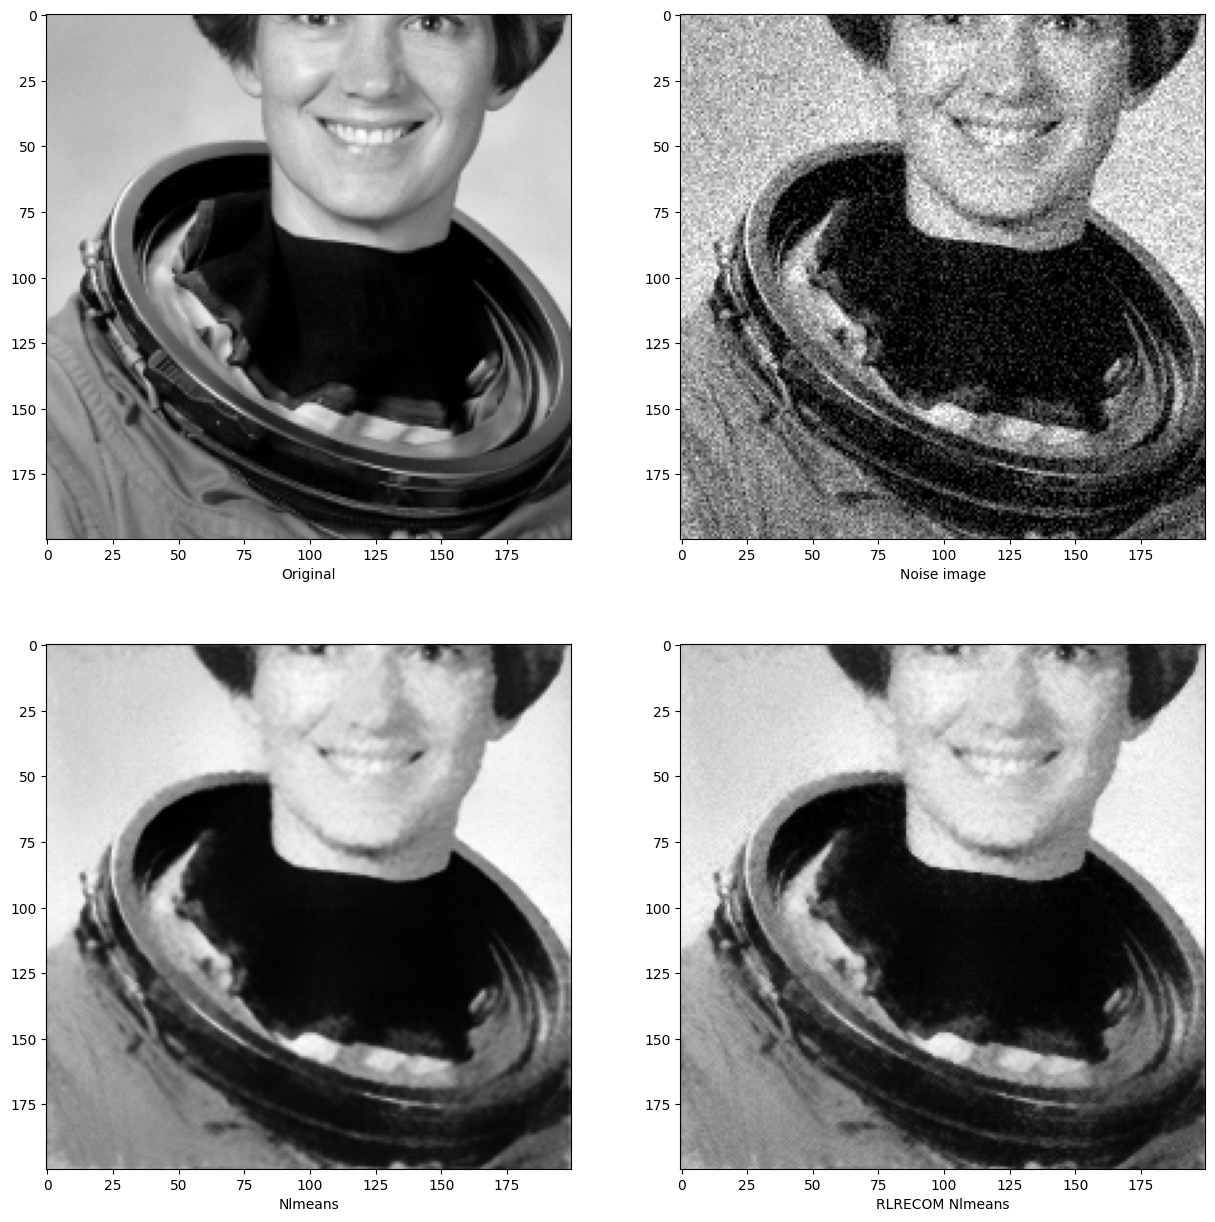

Noise    Nlmeans  RLRECOM Nlmeans  NONE Nlmeans
PSNR  20.582626  24.478626        24.574499     24.560339
SSIM   0.450165   0.720574         0.700518      0.705158
MSE    0.008745   0.002515         0.002506      0.002504

In [29]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

### K

In [30]:
%%time
# For speed porpuses only a subset of the values accepted by k will be tested (testing all the possible values for k
# could spend up to 80 hours).
start    = 3
end      = 22
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
ssims    = np.zeros(iter_num)
ssim_max = 0
best_k   = start
best_im  = None

for i, k in enumerate(possible_values):
    udl_params['k'] = k
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        ssim_value = image_metrics(im, im_fil3)[1] 
        print(udl_params, ssim_value, sep='\t')
        if ssim_value > ssim_max:
            ssim_max = ssim_value
            best_k   = k
            best_im  = im_fil3
        ssims[i] = ssim_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['k'] = best_k
print('\nFinal params:')
print(udl_params, ssim_max, sep='\t')

{'k': 3, 'lambda': 2, 'epsilon': 0.0125}	0.7005176533611545
{'k': 4, 'lambda': 2, 'epsilon': 0.0125}	0.7004413310233053
{'k': 5, 'lambda': 2, 'epsilon': 0.0125}	0.7004753578528523
{'k': 6, 'lambda': 2, 'epsilon': 0.0125}	0.7003583470036173
{'k': 7, 'lambda': 2, 'epsilon': 0.0125}	0.7003876928578286
{'k': 8, 'lambda': 2, 'epsilon': 0.0125}	0.7002495678083149
{'k': 9, 'lambda': 2, 'epsilon': 0.0125}	0.6999839434908416
{'k': 10, 'lambda': 2, 'epsilon': 0.0125}	0.6997883216220784
{'k': 11, 'lambda': 2, 'epsilon': 0.0125}	0.6997116635077391
{'k': 12, 'lambda': 2, 'epsilon': 0.0125}	0.699580445838131
{'k': 13, 'lambda': 2, 'epsilon': 0.0125}	0.6991391668142631
{'k': 14, 'lambda': 2, 'epsilon': 0.0125}	0.6990234495345767
{'k': 15, 'lambda': 2, 'epsilon': 0.0125}	0.6986045877572822
{'k': 16, 'lambda': 2, 'epsilon': 0.0125}	0.6981606898922913
{'k': 17, 'lambda': 2, 'epsilon': 0.0125}	0.6978697254804909
{'k': 18, 'lambda': 2, 'epsilon': 0.0125}	0.6979688878215516
{'k': 19, 'lambda': 2, 'epsilon'

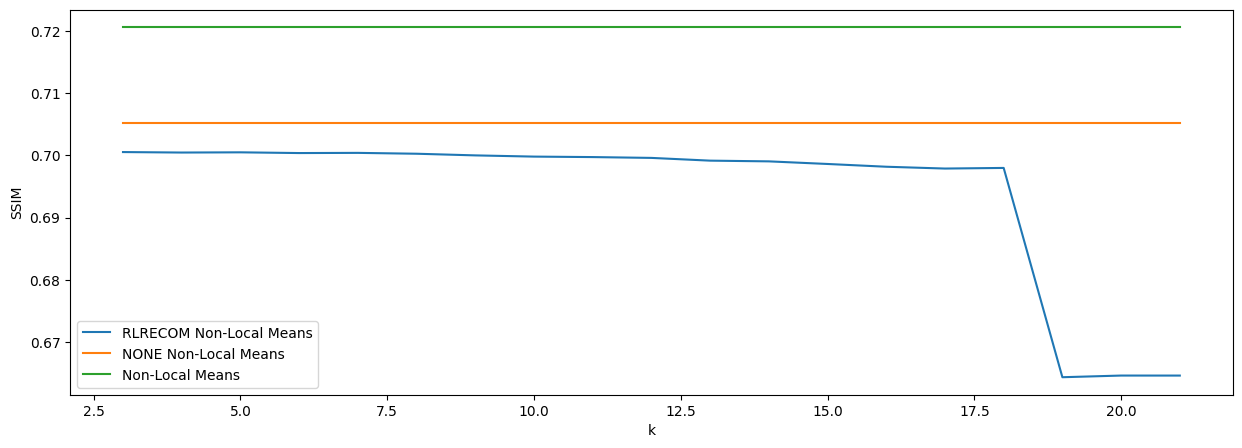

In [31]:
udlf_plot, = plt.plot(possible_values, ssims, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_ssim] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_ssim] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k')
plt.ylabel('SSIM')
if save_data:
    plt.savefig(os.path.join(out_dir, 'k_tuning_plot.png'))

### Lambda

In [32]:
%%time
start    = 2
end      = 22
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
ssims    = np.zeros(iter_num)
best_lbd = start

for i, lbd in enumerate(possible_values):
    udl_params['lambda'] = lbd
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        ssim_value = image_metrics(im, im_fil3)[1] 
        print(udl_params, ssim_value, sep='\t')
        if ssim_value > ssim_max:
            ssim_max = ssim_value
            best_lbd = lbd
            best_im  = im_fil3
        ssims[i] = ssim_value
    except:
        print('Finished with error on param:', lbd)
        break
        
# Update method parameters
udl_params['lambda'] = best_lbd
print('\nFinal params:')
print(udl_params, ssim_max, sep='\t')

{'k': 3, 'lambda': 2, 'epsilon': 0.0125}	0.7005176533611545
{'k': 3, 'lambda': 3, 'epsilon': 0.0125}	0.7005486722068385
{'k': 3, 'lambda': 4, 'epsilon': 0.0125}	0.7005142208926302
{'k': 3, 'lambda': 5, 'epsilon': 0.0125}	0.700487974603218
{'k': 3, 'lambda': 6, 'epsilon': 0.0125}	0.7004528950620391
{'k': 3, 'lambda': 7, 'epsilon': 0.0125}	0.7004650868518913
{'k': 3, 'lambda': 8, 'epsilon': 0.0125}	0.7004356778115681
{'k': 3, 'lambda': 9, 'epsilon': 0.0125}	0.7004317931719289
{'k': 3, 'lambda': 10, 'epsilon': 0.0125}	0.7004161014573921
{'k': 3, 'lambda': 11, 'epsilon': 0.0125}	0.7004084592389211
{'k': 3, 'lambda': 12, 'epsilon': 0.0125}	0.7003769602036287
{'k': 3, 'lambda': 13, 'epsilon': 0.0125}	0.7003653657706337
{'k': 3, 'lambda': 14, 'epsilon': 0.0125}	0.7003361556415904
{'k': 3, 'lambda': 15, 'epsilon': 0.0125}	0.7003407245134531
{'k': 3, 'lambda': 16, 'epsilon': 0.0125}	0.7003432916338422
{'k': 3, 'lambda': 17, 'epsilon': 0.0125}	0.7003510474158818
{'k': 3, 'lambda': 18, 'epsilon':

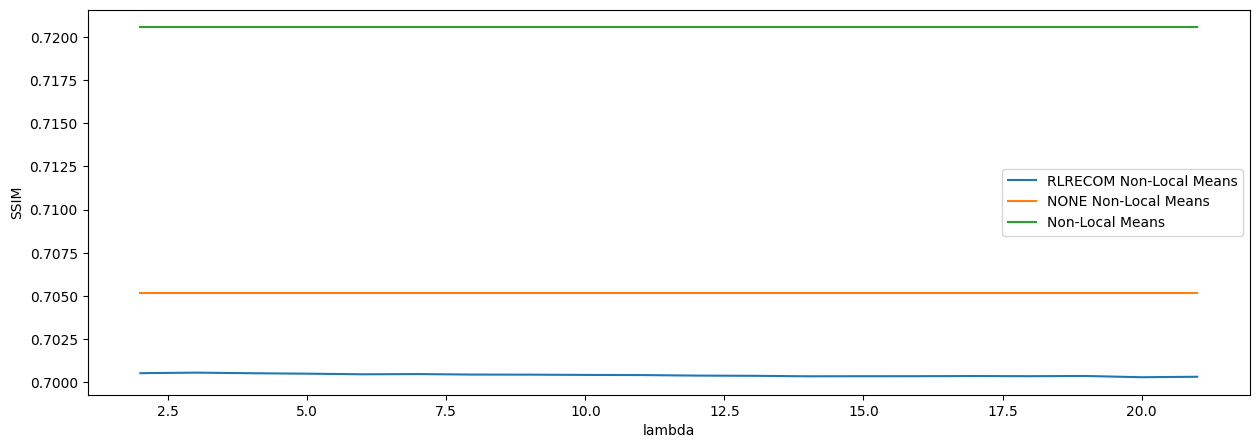

In [33]:
udlf_plot, = plt.plot(possible_values, ssims, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_ssim] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_ssim] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('lambda')
plt.ylabel('SSIM')
if save_data:
    plt.savefig(os.path.join(out_dir, 'lambda_tuning_plot.png'))

### Epsilon

In [34]:
%%time
start    = 0.0125
end      = 0.05
step     = 0.002
possible_values = np.arange(start, end, step)
iter_num = len(possible_values)
ssims    = np.zeros(int(iter_num))
best_eps = start

for i, eps in enumerate(possible_values):
    eps = round(eps, 5)
    udl_params['epsilon'] = eps
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        ssim_value = image_metrics(im, im_fil3)[1]
        print(udl_params, ssim_value, sep='\t')
        if ssim_value > ssim_max:
            ssim_max = ssim_value
            best_eps = eps
            best_im  = im_fil3
        ssims[i] = ssim_value
    except:
        print('Finished with error on param:', eps)
        break
        
# Update method parameters
udl_params['epsilon'] = best_eps
print('\nFinal params:')
print(udl_params, ssim_max, sep='\t')

{'k': 3, 'lambda': 3, 'epsilon': 0.0125}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0145}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0165}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0185}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0205}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0225}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0245}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0265}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0285}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0305}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0325}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0345}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0365}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0385}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0405}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0425}	0.7005486722068385
{'k': 3, 'lambda': 3, 'epsilon': 0.0445}

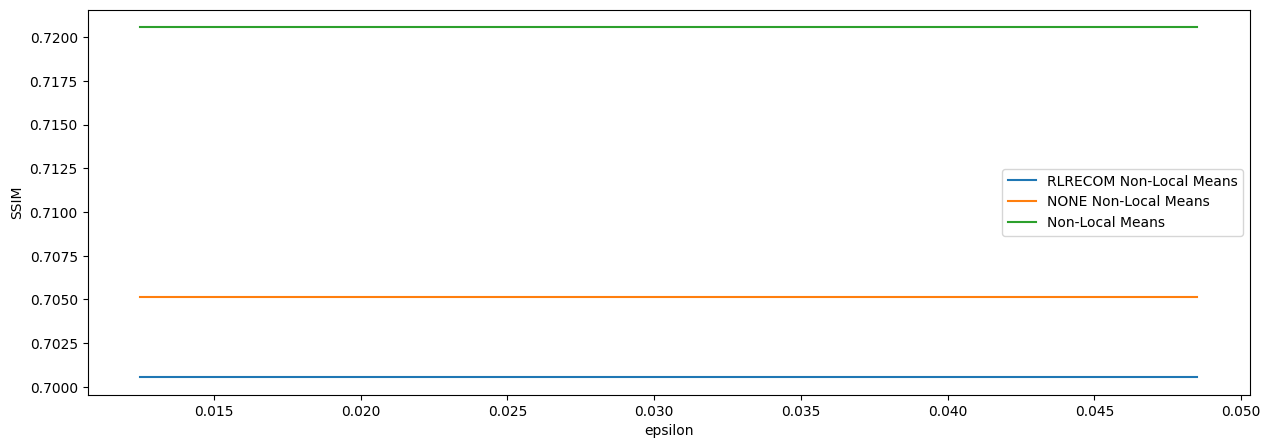

In [35]:
udlf_plot, = plt.plot(possible_values, ssims, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_ssim] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_ssim] * int(iter_num), label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('epsilon')
plt.ylabel('SSIM')
if save_data:
    plt.savefig(os.path.join(out_dir, 'epsilon_tuning_plot.png'))

### Final Result

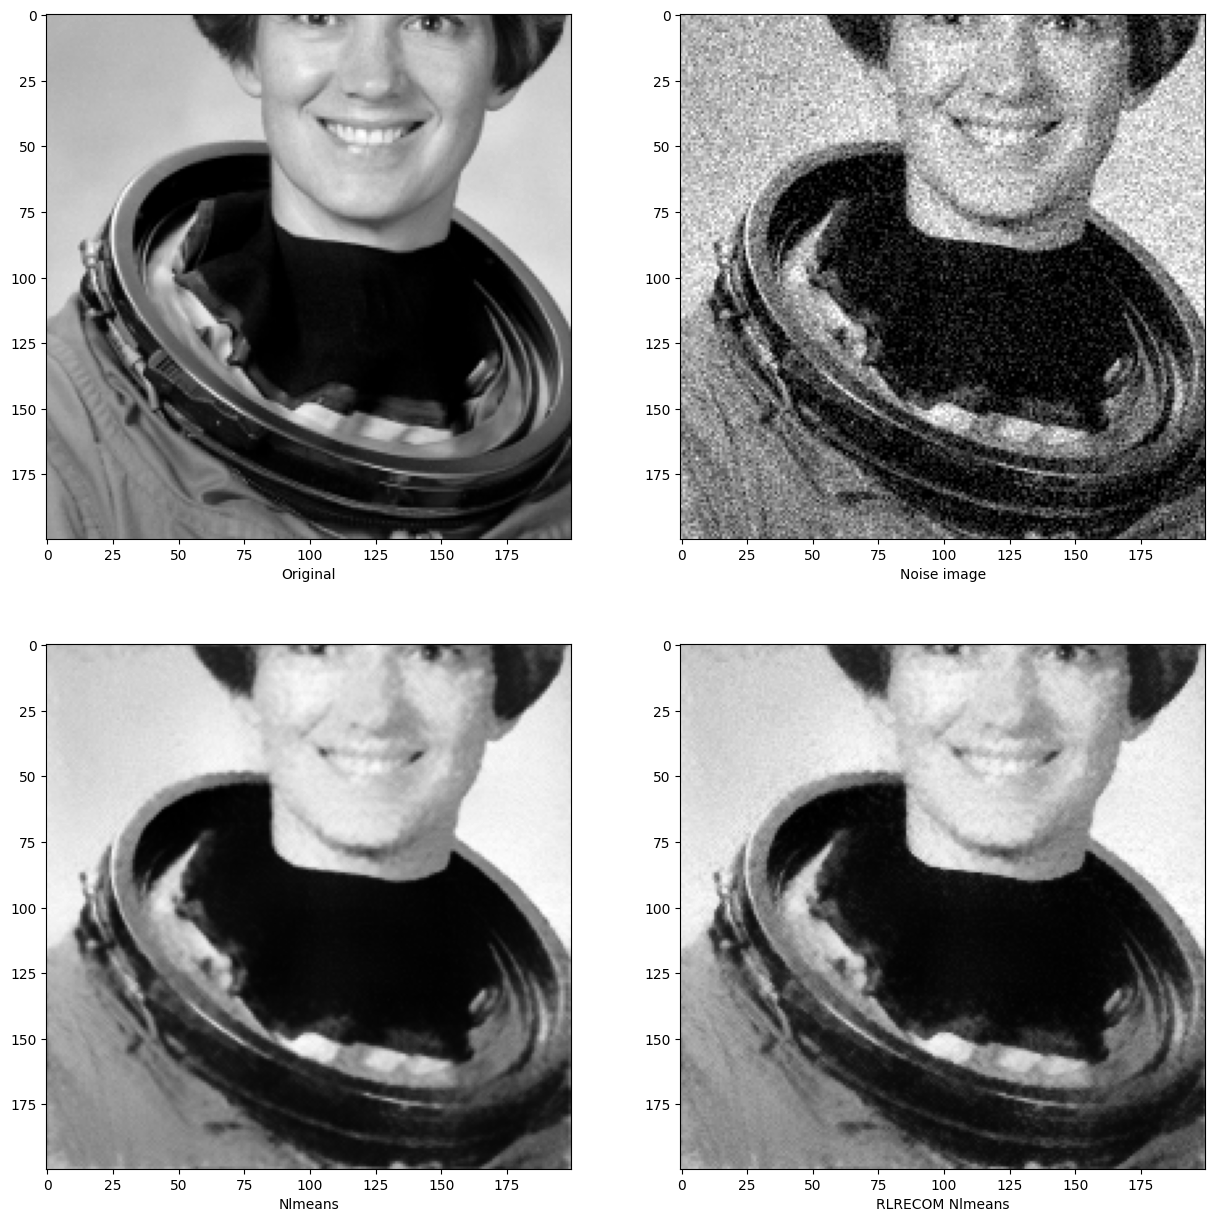

Noise    Nlmeans    RLRECOM       NONE
PSNR  20.582626  24.478626  24.576054  24.560339
SSIM   0.450165   0.720574   0.700549   0.705158
MSE    0.008745   0.002515   0.002505   0.002504

In [36]:
im_fil2 = best_im

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE'],
)

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [37]:
%%time
import sys

eval_info = []
eval_psnr = []
eval_ssim = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    im, im_name = get_image(image)
    im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

    # In case of error, the functions above return None
    if im is None:
        continue
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 

    # Save the images if requested
    if save_data:
        plt.imsave(os.path.join(out_dir, f'{image}.png'), im)
        plt.imsave(os.path.join(out_dir, f'{image}_noise.png'), im_nse)
        plt.imsave(os.path.join(out_dir, f'{image}_nlm.png'), im_fil1)
        plt.imsave(os.path.join(out_dir, f'{image}_{udl_method}.png'), im_fil2)
        plt.imsave(os.path.join(out_dir, f'{image}_NONE.png'), im_fil3)
        
    # Evaluation
    im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
    im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
    im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
    im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    eval_ssim.append([im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape, im.dtype)

Method: RLRECOM
Parameters: {'k': 3, 'lambda': 3, 'epsilon': 0.0125}
Tested with image: astronaut (200, 200) float64
Tested with image: binary_blobs (200, 200) float64
Tested with image: brick (200, 200) float64
Tested with image: camera (200, 200) float64
Tested with image: cat (200, 200) float64
Tested with image: checkerboard (200, 200) float64
Tested with image: clock (200, 200) float64
Tested with image: coffee (200, 200) float64
Tested with image: coins (200, 200) float64
Tested with image: eagle (200, 200) float64
Tested with image: grass (200, 200) float64
Tested with image: gravel (200, 200) float64
Tested with image: horse (200, 200) float64
Tested with image: page (191, 191) float64
Tested with image: text (172, 172) float64
Tested with image: rocket (200, 200) float64
CPU times: user 4min 49s, sys: 17.2 s, total: 5min 7s
Wall time: 7min 19s


### Results

In [38]:
results_psnr_df = pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'PSNR')
print('Number of images tested:', len(images_tested))
results_psnr_df.style.apply(highlight_best_values, axis=1)

RLRECOM {'k': 3, 'lambda': 3, 'epsilon': 0.0125} PSNR
Number of images tested: 16


In [39]:
results_ssim_df = pd.DataFrame(
    data = eval_ssim,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'SSIM')
print('Number of images tested:', len(images_tested))
results_ssim_df.style.apply(highlight_best_values, axis=1)

RLRECOM {'k': 3, 'lambda': 3, 'epsilon': 0.0125} SSIM
Number of images tested: 16


In [40]:
results_psnr_df[results_psnr_df['RLRECOM'] > results_psnr_df['Nlmeans']]

Noise    Nlmeans    RLRECOM       NONE
astronaut     20.582626  24.478626  24.576054  24.560339
binary_blobs  22.974166  28.101368  28.213208  28.226245
cat           20.010958  23.065350  23.240385  23.207642
coins         20.291328  23.692474  23.695385  23.539467
grass         19.994935  18.347285  18.907555  18.702643
gravel        20.003076  21.063408  21.177101  21.018437
horse         22.916317  28.036932  28.064573  28.113217
page          20.021616  21.090167  21.401102  21.259268

In [41]:
results_ssim_df[results_ssim_df['RLRECOM'] > results_ssim_df['Nlmeans']]

Noise   Nlmeans   RLRECOM      NONE
cat     0.385863  0.589126  0.597703  0.596406
grass   0.688167  0.673109  0.723705  0.704803
gravel  0.669583  0.765514  0.784481  0.772173

In [42]:
if save_data:
    import json
    results_psnr_df.to_csv(os.path.join(out_dir, 'results_psnr.csv'))
    results_ssim_df.to_csv(os.path.join(out_dir, 'results_ssim.csv'))
    with open(os.path.join(out_dir, 'params.json'), 'w') as fp:
        json.dump({
            'hP': hP,
            'hW': hW,
            'tau': tau,
            'sig': sig,
            'shape': shape,
            'n_w': n_w,
            'seed': seed,
            'udl_method': udl_method,
            'udl_params': udl_params,
            'tuning_method': 'simple'
        }, fp)